Authors: Tim Gorman, Yu Cao, Ling Zhou

---

Data analyzed in this notebook is from [Kaggle's code competation: Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching/data). The data comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe.

In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# from googletrans import Translator, constants
import seaborn as sns
import langdetect
from langdetect import detect
import matplotlib.pyplot as plt

from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd

Note: To install geopandas, open a terminal in jupyter and run the following commands

pip install pipwin <br>
pipwin install gdal <br>
pipwin install fiona <br>
pip install geopandas

# Exploring `train.csv`

## Basic information

In [4]:
df_train = pd.read_csv("../../code-2022/final_project/data-foursquare-location-matching/train.csv")
# df_train  = pd.read_csv("../../data_raw/train.csv")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138812 entries, 0 to 1138811
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 1138812 non-null  object 
 1   name               1138811 non-null  object 
 2   latitude           1138812 non-null  float64
 3   longitude          1138812 non-null  float64
 4   address            742191 non-null   object 
 5   city               839623 non-null   object 
 6   state              718226 non-null   object 
 7   zip                543386 non-null   object 
 8   country            1138801 non-null  object 
 9   url                267724 non-null   object 
 10  phone              342855 non-null   object 
 11  categories         1040505 non-null  object 
 12  point_of_interest  1138812 non-null  object 
dtypes: float64(2), object(11)
memory usage: 112.9+ MB


In [6]:
df_train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [7]:
df_train.shape

(1138812, 13)

## Missing values
- Every row has the features: `id`, `latitude`, `longitude`, `point_of_interest`
- Other features have missing values
- Features that have less missing values: `name`, `country`, `categories`

In [8]:
print('There are', len(set(df_train.id)), 'id, and', len(set(df_train.point_of_interest)), 'distinct POIs.\n')
print('About', np.round(len(set(df_train.point_of_interest))/len(set(df_train.id))*100,2),'% POIs are unique.\n')

There are 1138812 id, and 739972 distinct POIs.

About 64.98 % POIs are unique.



id                    0.000000
latitude              0.000000
longitude             0.000000
point_of_interest     0.000000
name                  0.000088
country               0.000966
categories            8.632417
city                 26.272027
address              34.827610
state                36.931996
zip                  52.284837
phone                69.893626
url                  76.490940
dtype: float64


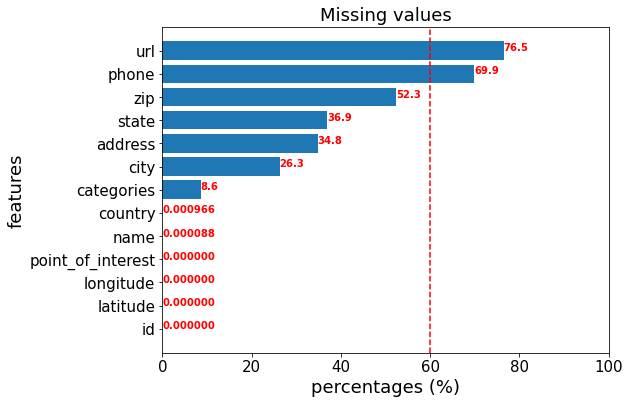

In [11]:
df = df_train
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y)
ax.set_title("Missing values", fontsize=18)
ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'red', fontweight = 'bold')
    else:
        ax.text(value, index, '{:.1f}'.format(value), color = 'red', fontweight = 'bold')
plt.show()

## Features in `train.csv`

In [12]:
df.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest'],
      dtype='object')

### `id`

In [13]:
# each value in `id` is unique.
print("Each value in `id` is unique:", len(df.id.unique()) == df.shape[0])

Each value in `id` is unique: True


### `latitude` and `longitude`

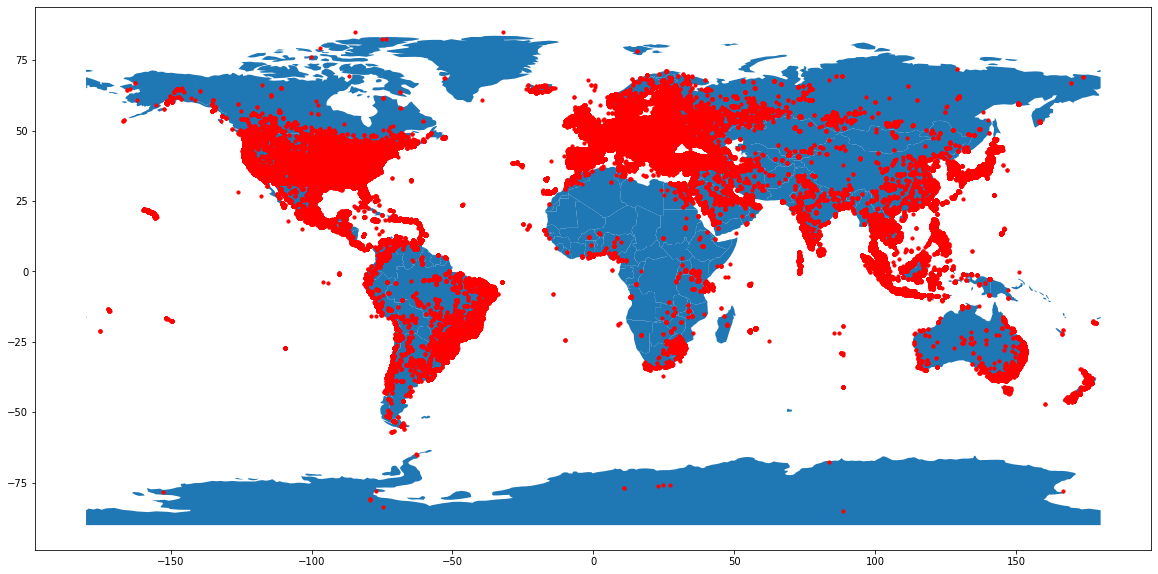

In [14]:
# simple sketch
# fig, ax = plt.subplots(figsize=(40,25))
# ax.scatter(df_train['longitude'],df_train['latitude'])
# ax.set_xlabel('longitude',fontsize=40)
# ax.set_ylabel('latitude',fontsize=40)
# ax.tick_params(axis='both', labelsize=40)
# ax.grid()
# plt.show()

# fancy plot
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df_train.copy(), geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20, 12))
world.plot(figsize=(20, 12), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=10)

fig.savefig("./train_coords.png")
plt.show()

### `name`

This column has different languages. 

In [16]:
df['name']

0                    Café Stad Oudenaarde
1                          Carioca Manero
2                        ร้านตัดผมการาเกด
3                                Turkcell
4                 Restaurante Casa Cofiño
                        ...              
1138807                              青ガエル
1138808                      Deshon Place
1138809    İzmir Adnan Menderes Havaalanı
1138810                             焼肉 和家
1138811                       Waihi Beach
Name: name, Length: 1138812, dtype: object

In [ ]:
# Takes a few minutes.
# flag = 0
# lang = []
# for row in df['name'].dropna():
#     if flag > 20:
#         break
#     try:
#         lang.append(detect(row))
#     except:
#         flag += 1
#         language = "error"
#         print("This row throws and error:", row)
# print(set(lang))

### How Many Languages are Present?

In [46]:
languages = []
name_data = df_train['name'].sample(10000).fillna('').str.replace('[{}]'.format(string.punctuation),'').str.lower()
for item in name_data:
    try:
        if item != '':
            languages.append(detect(item))
        pass
    except langdetect.LangDetectException as e:
        print(item)
        continue

/var/folders/c6/0skdqs2s0ps3221n46960ds80000gn/T/ipykernel_22092/778084432.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  name_data = df_train['name'].sample(10000).fillna('').str.replace('[{}]'.format(string.punctuation),'').str.lower()


3205
5 18
34137


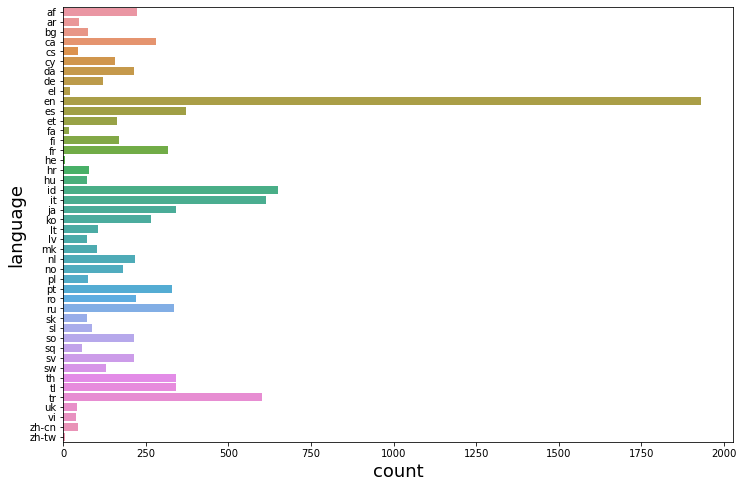

In [72]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y = languages, ax=ax, orient='v')
ax.set_xlabel("count", fontsize=18)
ax.set_ylabel("language", fontsize=18)
ax.tick_params(labelsize=10)
plt.show()

In [61]:
type(languages)

list

In [ ]:
languages.count('en')/len(languages)

0.19125737721316394

So roughly 20% of the sampled data is in English.

### `country` 

Data availability


(10,)


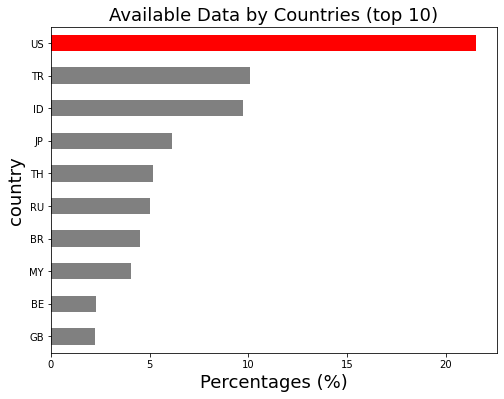

In [18]:
country_stats = df['country'].value_counts()*100/df['country'].value_counts().sum()
country_stats = country_stats.head(10).sort_values()
print(country_stats.shape)

fig, ax = plt.subplots(figsize=(8,6))
color = ["gray"]*len(country_stats.index)
color[-1] = "red"
country_stats.plot(kind = 'barh', ax = ax, color = color)

ax.set_title("Available Data by Countries (top 10)", fontsize = 18)
ax.set_ylabel('country', fontsize = 18)
ax.set_xlabel('Percentages (%)', fontsize = 18)
plt.show()

### `point_of_interest`

In [19]:
df['point_of_interest'].value_counts()

P_fb339198a31db3    332
P_3a3fbd26e16269    199
P_f70a0977377171    166
P_9290e406eb58ac    145
P_fbe61733fcdebe    132
                   ... 
P_ed44fbd056eb4d      1
P_6601e86230f550      1
P_36404ebf8565ee      1
P_3270f1f5b135b9      1
P_ea6578bf39b406      1
Name: point_of_interest, Length: 739972, dtype: int64

In [20]:
tmp = df[df['point_of_interest']=='P_399ab9d64f2a2e'].sort_values(by='point_of_interest')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
1517,E_005b1a6f97ca7b,Nationwide Insurance,39.962014,-82.885847,583 S Yearling Rd,Columbus,OH,43213,US,http://t.co/4eDIQ4ptQn,+16145752643,Financial or Legal Services,P_399ab9d64f2a2e
526905,E_7667106372e795,Nationwide Insurance - Monica M Radke,37.576416,-77.443130,11428 Belvedere Vista Ln,North Chesterfield,VA,23235,US,http://t.co/4eDIQ4ptQn,+18046585233,Financial or Legal Services,P_399ab9d64f2a2e
539146,E_79295816ef8549,Nationwide Insurance - Ruben Saucedo Agency,32.756500,-96.822220,1112 N Zang Blvd,Dallas,TX,75203,US,http://t.co/4eDIQ4ptQn,+12149428500,Financial or Legal Services,P_399ab9d64f2a2e
543303,E_7a17b3160fa7eb,Nationwide Insurance - Kent Kiesewetter,30.644263,-94.873782,8 N Main St,Kingwood,TX,77339,US,http://t.co/4eDIQ4ptQn,+12815487003,Financial or Legal Services,P_399ab9d64f2a2e
582169,E_82db401372a141,Nationwide Insurance - Alison Maureen Rielli A...,38.607881,-121.435018,2251 Harvard St,Sacramento,CA,95815,US,http://t.co/4eDIQ4ptQn,+19169152744,Financial or Legal Services,P_399ab9d64f2a2e


In [21]:
tmp = df[df['point_of_interest']=='P_ce9291000a8f0b'].sort_values(by='point_of_interest')
tmp.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
19594,E_04656287079d09,"Cara J. Lasley, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/1877...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
647358,E_917cf32095d31e,"Naomi F. Lauriello, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/2202...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
648768,E_91ceb13234ef44,"Stephen J. Falchek, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/973/...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
670884,E_96b3145a11cf21,"Steven L. Blumer, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/787/...,+18004164441,Doctor's Offices,P_ce9291000a8f0b
675333,E_97b2cb975f93b7,"Takeshi Tsuda, MD",39.779379,-75.555298,1600 Rockland Rd,Wilmington,DE,19803,US,https://findaprovider.nemours.org/details/1261...,+18004164441,Doctor's Offices,P_ce9291000a8f0b


# The US data in `train.csv`

We focus on the US data in `train.csv` to have a smaller data set.

In [22]:
df_us = df[df['country']=='US']

In [23]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245284 entries, 8 to 1138808
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 245284 non-null  object 
 1   name               245283 non-null  object 
 2   latitude           245284 non-null  float64
 3   longitude          245284 non-null  float64
 4   address            188824 non-null  object 
 5   city               236241 non-null  object 
 6   state              239373 non-null  object 
 7   zip                213277 non-null  object 
 8   country            245284 non-null  object 
 9   url                99477 non-null   object 
 10  phone              131597 non-null  object 
 11  categories         232133 non-null  object 
 12  point_of_interest  245284 non-null  object 
dtypes: float64(2), object(11)
memory usage: 26.2+ MB


## Missing values

id                    0.000000
latitude              0.000000
longitude             0.000000
country               0.000000
point_of_interest     0.000000
name                  0.000408
state                 2.409860
city                  3.686747
categories            5.361540
zip                  13.048955
address              23.018216
phone                46.349130
url                  59.444155
dtype: float64


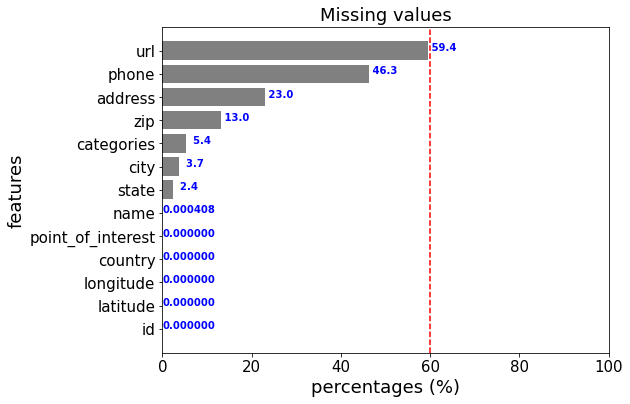

In [29]:
df = df_us
# Count the missing values in each feature
missing = df.isna().sum()/df.shape[0]*100
print(missing.sort_values())

# Plot the percentages of missing values for each feature
import matplotlib.ticker as mtick
tmp = df.isna().sum().sort_values()
fig, ax = plt.subplots(figsize=(8,6))

y = tmp/len(df)*100
ax.barh(tmp.index, y, color = 'gray')
ax.set_title("Missing values", fontsize=18)
ax.axvline(x=60,color='r',linestyle='--')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(axis='both', labelsize=15 )
ax.set_ylabel('features', fontsize=18)
ax.set_xlabel('percentages (%)', fontsize=18)
ax.set_xlim(0,100)

for index, value in enumerate(y):
    if value < 1:
        ax.text(value, index, '{:.6f}'.format(value), color = 'blue', fontweight = 'bold')
    else:
        ax.text(value, index, '{:5.1f}'.format(value), color = 'blue', fontweight = 'bold')
plt.show()

Should throw away the `url` column because about 60% data are missing.

In [30]:
df_train[df_train['country'].isna()].head(3)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
45891,E_0a44b45f734139,"Markham, Maerua Mall",-22.583108,17.093568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Men's Stores,P_845763d172f88e
201697,E_2d417f61d76741,Wernhill Park,-22.567297,17.082069,NaN,Windhoek,Khomas,NaN,NaN,NaN,NaN,Shopping Malls,P_5ffceb1c2ec3cd
253807,E_3900936ca2996a,Hilton Windhoek,-22.570327,17.085307,Rev. Michael Scott Street,Windhoek,Khomas,70,NaN,http://windhoek.hilton.com,612962929,NaN,P_d7df3f321a984f


In [31]:
df_train[df_train['name'].isna()].head(3)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
750648,E_a8a20800af4423,NaN,40.822332,-96.689102,NaN,NaN,AK,NaN,US,NaN,NaN,NaN,P_be5d12315d8588


## Features in the US set

### `name`

In [34]:
# # Takes a few minutes.
# df = df_us
# flag = 0
# lang = []
# for row in df['name'].dropna():
#     if flag > 20:
#         break
#     try:
#         lang.append(detect(row))
#     except:
#         flag += 1
#         language = "error"
#         print("This row throws and error:", row)
# print(set(lang))

In [35]:
tmp = df_us['name'].sort_values()
tmp

622268                               "#208 \"Comfort Inn\""
769105                  "Access Health Care, LLC \"Adams\""
885613                 "Access Health Care, LLC \"Howell\""
779271    "Alfredo's Beach Club's \"Sunsets On The Beach...
493745                       "AmVets Post #2 \"Post Home\""
                                ...                        
150203                                   Kaleigh's Krib
513853                                              Heaven
121260                                  ﻿V Bar Ultra Lounge
474973                                   💇 Hair By CHiiNK 💋
750648                                                  NaN
Name: name, Length: 245284, dtype: object

### `point_of_interest`

Notes on the `point_of_interest` feature:
https://www.kaggle.com/competitions/foursquare-location-matching/discussion/318967#1783581

In [36]:
print('Number of (unique) POIs : {:8d}'.format(len(df_train['point_of_interest'].unique())))
print('Number of (unique) ids  : {:8d}'.format(len(df_train['id'].unique())))

Number of (unique) POIs :   739972
Number of (unique) ids  :  1138812


In [37]:
df_us['point_of_interest'].value_counts().head(10)

P_399ab9d64f2a2e    58
P_ce9291000a8f0b    46
P_a3fddc2f0a77e7    37
P_d89437d5f1169c    35
P_5cf56bf7bdf7ae    29
P_fff25ec89e22da    28
P_0c880e80aaa19f    26
P_bae8584591fe1a    26
P_1e8e17b542e178    25
P_4efd9da6085caf    25
Name: point_of_interest, dtype: int64

In [38]:
# Noise: same POI with different physical places; sorted by 'name'.
df_us.loc[df_us['point_of_interest']=='P_399ab9d64f2a2e',
          ['name','latitude','longitude','city','state','zip','categories','point_of_interest']].sort_values(by='name').head(10)

,name,latitude,longitude,city,state,zip,categories,point_of_interest
642307,Gregg Steiner - Nationwide Insurance & Financi...,33.607341,-117.877248,Newport Beach,CA,92660,Financial or Legal Services,P_399ab9d64f2a2e
268102,James S Wills Agency - Nationwide Insurance,34.002130,-81.772107,Saluda,SC,29138,NaN,P_399ab9d64f2a2e
1517,Nationwide Insurance,39.962014,-82.885847,Columbus,OH,43213,Financial or Legal Services,P_399ab9d64f2a2e
585453,Nationwide Insurance,39.280624,-76.611005,Baltimore,MD,21230,Financial or Legal Services,P_399ab9d64f2a2e
233839,Nationwide Insurance,41.224360,-73.071814,Milford,CT,06460,Financial or Legal Services,P_399ab9d64f2a2e
205941,Nationwide Insurance,35.726227,-79.465096,Siler City,NC,27344,Financial or Legal Services,P_399ab9d64f2a2e
1109854,Nationwide Insurance,37.771586,-122.276649,Alameda,CA,94501,Financial or Legal Services,P_399ab9d64f2a2e
147100,Nationwide Insurance,35.991922,-80.028573,High Point,NC,27262,Financial or Legal Services,P_399ab9d64f2a2e
416436,Nationwide Insurance - AOK Agency,41.594937,-83.647413,Toledo,OH,43614,Financial or Legal Services,P_399ab9d64f2a2e
818454,Nationwide Insurance - Alexandra Ramos Agency,40.145845,-82.945719,Westerville,OH,43082,Financial or Legal Services,P_399ab9d64f2a2e


In [39]:
# Noise: same POI with different physical places; sorted by 'state'.
df_us.loc[df_us['point_of_interest']=='P_399ab9d64f2a2e',
          ['name','latitude','longitude','city','state','zip','categories','point_of_interest']].sort_values(by='state').head(10)

,name,latitude,longitude,city,state,zip,categories,point_of_interest
161948,Nationwide Insurance - Bruce Sargent Insurance...,34.262962,-92.084663,White Hall,AR,71602,Financial or Legal Services,P_399ab9d64f2a2e
193359,Nationwide Insurance - Gates Ins Inc,33.396255,-111.684190,Mesa,AZ,85206,Financial or Legal Services,P_399ab9d64f2a2e
1109854,Nationwide Insurance,37.771586,-122.276649,Alameda,CA,94501,Financial or Legal Services,P_399ab9d64f2a2e
642307,Gregg Steiner - Nationwide Insurance & Financi...,33.607341,-117.877248,Newport Beach,CA,92660,Financial or Legal Services,P_399ab9d64f2a2e
582169,Nationwide Insurance - Alison Maureen Rielli A...,38.607881,-121.435018,Sacramento,CA,95815,Financial or Legal Services,P_399ab9d64f2a2e
52883,Nationwide Insurance - Ronald Scott Madden Agency,36.828552,-119.701050,Clovis,CA,93612,Financial or Legal Services,P_399ab9d64f2a2e
630340,Nationwide Insurance - Colorado Insurance Group,39.678352,-105.082184,Denver,CO,80246,Financial or Legal Services,P_399ab9d64f2a2e
233839,Nationwide Insurance,41.224360,-73.071814,Milford,CT,06460,Financial or Legal Services,P_399ab9d64f2a2e
272625,Nationwide Insurance - Bryan Slater Agency,33.740365,-84.392853,Atlanta,GA,30312,Financial or Legal Services,P_399ab9d64f2a2e
1009171,Nationwide Insurance - Nicholas Greene Agency,34.111238,-84.039890,Sugar Hill,GA,30518,Financial or Legal Services,P_399ab9d64f2a2e


In [40]:
# Noise: same POI with different physical places; sorted by 'city'.
df_us.loc[df_us['point_of_interest']=='P_399ab9d64f2a2e',
          ['name','latitude','longitude','city','state','zip','categories','point_of_interest']].sort_values(by='city').head(10)
# df_us[df_us['name']=='CVS'].sort_values(by='point_of_interest').head()

,name,latitude,longitude,city,state,zip,categories,point_of_interest
1109854,Nationwide Insurance,37.771586,-122.276649,Alameda,CA,94501,Financial or Legal Services,P_399ab9d64f2a2e
272625,Nationwide Insurance - Bryan Slater Agency,33.740365,-84.392853,Atlanta,GA,30312,Financial or Legal Services,P_399ab9d64f2a2e
671771,Nationwide Insurance - Corrigan Insurance Agen...,39.280465,-76.610727,Baltimore,MD,21230,Financial or Legal Services,P_399ab9d64f2a2e
585453,Nationwide Insurance,39.280624,-76.611005,Baltimore,MD,21230,Financial or Legal Services,P_399ab9d64f2a2e
472930,Nationwide Insurance - Robertson Financial Group,39.280121,-80.233749,Bridgeport,WV,26330,Financial or Legal Services,P_399ab9d64f2a2e
748106,Nationwide Insurance - Michael Glick Agency Inc,36.080887,-79.474373,Burlington,NC,27215,Financial or Legal Services,P_399ab9d64f2a2e
675426,Nationwide Insurance - Bouldin Williams Agency...,36.072111,-79.427535,Burlington,NC,27215,Financial or Legal Services,P_399ab9d64f2a2e
418003,Nationwide Insurance - Mcglothin Insurance And Co,39.603920,-82.918571,Circleville,OH,43113,Financial or Legal Services,P_399ab9d64f2a2e
52883,Nationwide Insurance - Ronald Scott Madden Agency,36.828552,-119.701050,Clovis,CA,93612,Financial or Legal Services,P_399ab9d64f2a2e
303528,Nationwide Insurance - Thomas S Davis,36.201122,-76.767464,Colerain,NC,27924,Financial or Legal Services,P_399ab9d64f2a2e


### `state`

In [42]:
df_us['state'].unique()

array(['CA', 'GA', 'NM', 'FL', 'PA', 'VA', 'NJ', 'OH', 'WI', 'MO', 'SC',
       'TN', 'OR', 'AZ', 'TX', 'MD', 'NY', 'MI', 'MA', 'NC', 'UT', 'IN',
       'IL', nan, 'Calif', 'NV', 'KS', 'MS', 'WA', 'AL', 'OK', 'AR', 'CT',
       'KY', 'NE', 'WV', 'CO', 'HI', 'ID', 'LA', 'MN', 'MT', 'ME', 'NH',
       'nv', 'WY', 'IA', 'DE', 'RI', 'VT', 'il', 'ND', 'AK', 'DC', 'SD',
       'D.C.', 'Ia', 'Ohio', 'Nj', 'Georgia', 'Nc', 'de', 'New York',
       'New Jersey', 'Ca', 'texas', 'Pa', 'Missouri', 'pa', 'Tx',
       'Connecticut', 'Ok', 'co', 'wi', 'Va', 'Az', 'ca',
       'North Carolina', 'Tennessee', 'Pennsylvania', 'Florida',
       'Massachusetts', 'tx', 'Kansas', 'Ny', 'Ga', 'Virginia', 'fl',
       'Tamaulipas', 'LOUISIANA', 'nc', 'Il', 'California', 'Ma', 'PR',
       'wa', 'Maryland', 'ny', 'Illinois', 'District of Columbia', 'Iowa',
       'Texas', 'CE', 'Wisconsin', 'Fl', 'mi', 'az', 'Arkansas',
       'Capital Region of Denmark', 'Minnesota', 'Md', 'Tn',
       'Mississippi', 'Idaho', 

In [43]:
# Drop these.
filter_set = ['国外','UK','CE','ON/NY','Capital Region of Denmark','BCN','Tamaulipas','NU']
df_us[df_us['state'].isin(filter_set)]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
75113,E_10d0a514fabcc6,AutoZone,26.080340,-98.304671,Blvd. Hidalgo # 1750 Col. Morelos,Reynosa,Tamaulipas,88651,US,https://www.autozone.com.mx,8999238990,Automotive Shops,P_caaec985490160
153657,E_226eb110eb0a4e,Evevideo 8,40.771182,-73.977953,Av Pedro Alves,Acopiara,CE,63560-000,US,NaN,NaN,Conferences,P_ac5a6fb63841d4
182570,E_28f6a8c1810d42,Copenhagen Airport (CPH),55.613190,12.647946,NaN,Copenhagen,Capital Region of Denmark,NaN,US,NaN,NaN,Airports,P_de322dff6e3a8b
251224,E_3869cbc132af4a,Evevideo 1,40.770792,-73.976183,Av Pedro Alves,Acopiara,CE,63560-000,US,NaN,NaN,Conferences,P_ac5a6fb63841d4
295772,E_426b4d3c7f12cf,Evevideo 7,40.771361,-73.977191,Av Pedro Alves,Acopiara,CE,63560-000,US,NaN,NaN,Conferences,P_ac5a6fb63841d4
361799,E_514da8554757c7,Dulceria Alejandra,32.659417,-115.486806,NaN,Mexicali,BCN,NaN,US,NaN,NaN,Candy Stores,P_363b19f021fb6f
600387,E_86ee21433a06ce,Canada / US Border,42.907269,-78.907035,Peace Bridge,Fort Erie/Buffalo,ON/NY,NaN,US,NaN,NaN,Border Crossings,P_856fc237546080
738444,E_a5e59da858ec99,Wegmans Pharmacy,42.145954,-77.062603,24 S. Bridge St.,Corning,NU,14830,US,NaN,NaN,Pharmacies,P_fcf4397457178a
886639,E_c72776cf1d131b,boiling crab,37.302755,-121.864208,"1631 E Capitol Expy San Jose, CA 95121-1826 (4...",海外,国外,95121,US,NaN,NaN,NaN,P_0cc38b5ae552c4
918520,E_ce51ff08bea33e,"Albemarle Art Gallery, London UK",33.636645,-84.437706,Albermarle,London,UK,NaN,US,NaN,NaN,NaN,P_a2569d6f26dd5c


### `categories`

In [44]:
df_us.categories.sample(30)

254755                                 Ethiopian Restaurants
236277                               Home Services & Repairs
579231                                             Breweries
26639                            Financial or Legal Services
594782                                  Salons / Barbershops
636770                                               Offices
791308                                       Gyms, Buildings
1009860                                Ethiopian Restaurants
536059          Gas Stations, Car Washes, Convenience Stores
576858                                   Seafood Restaurants
881716                                                 Parks
1037774                                             Churches
831371                Mobile Phone Shops, Electronics Stores
90861                                             Cemeteries
81684                                             Wine Shops
241994                                      Doctor's Offices
791614                  

## The US data

In [ ]:
df_us = df_train[df_train['country']=='US']

In [ ]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245284 entries, 8 to 1138808
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 245284 non-null  object 
 1   name               245283 non-null  object 
 2   latitude           245284 non-null  float64
 3   longitude          245284 non-null  float64
 4   address            188824 non-null  object 
 5   city               236241 non-null  object 
 6   state              239373 non-null  object 
 7   zip                213277 non-null  object 
 8   country            245284 non-null  object 
 9   url                99477 non-null   object 
 10  phone              131597 non-null  object 
 11  categories         232133 non-null  object 
 12  point_of_interest  245284 non-null  object 
dtypes: float64(2), object(11)
memory usage: 26.2+ MB


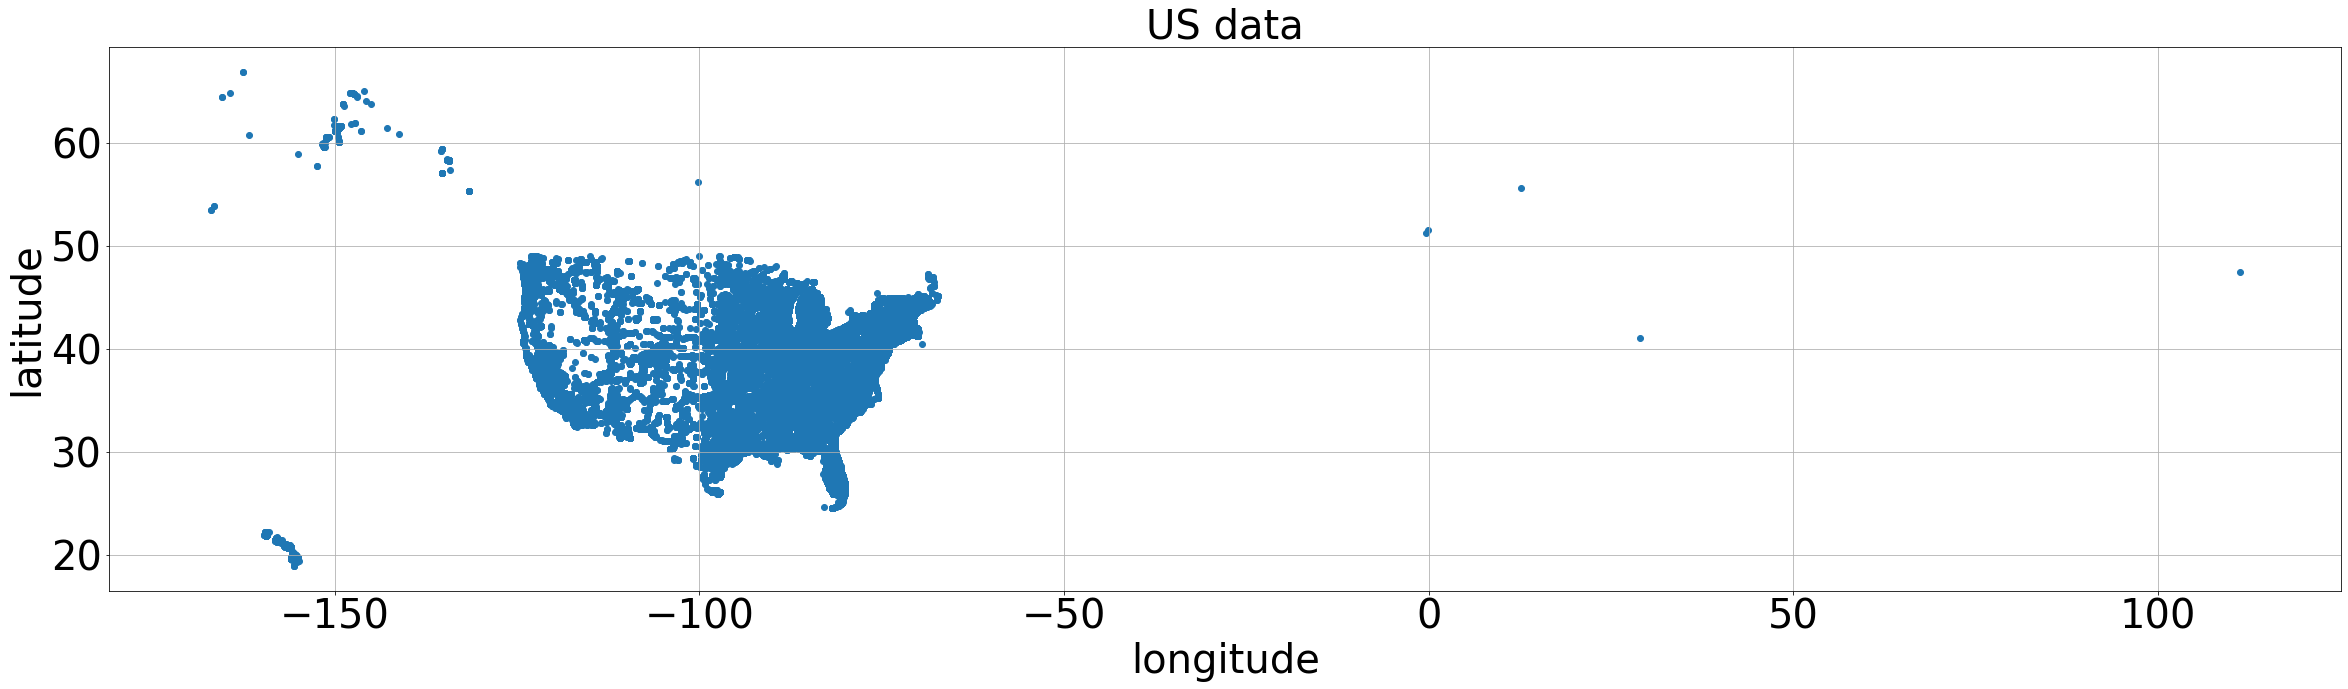

In [ ]:
fig, ax = plt.subplots(figsize=(40,10))
ax.scatter(df_us['longitude'],df_us['latitude'])
ax.set_xlabel('longitude',fontsize=40)
ax.set_ylabel('latitude',fontsize=40)
ax.tick_params(axis='both', labelsize=40)
ax.set_title('US data',fontsize=40)
ax.grid()
plt.show()

In [ ]:
df_us[df_us['longitude']>-50]

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
182570,E_28f6a8c1810d42,Copenhagen Airport (CPH),55.613190,12.647946,NaN,Copenhagen,Capital Region of Denmark,NaN,US,NaN,NaN,Airports,P_de322dff6e3a8b
411088,E_5c62949becf17d,"u.s. post office. Roland Park, Maryland",51.227604,-0.322765,Deepdene Avenue,NaN,NaN,NaN,US,http://www.postoffice.co.uk,NaN,Post Offices,P_c15c1ca3fd79fc
802054,E_b41d3d0482fa69,The App Business,51.531921,-0.119336,71 Collier Street,London,London,N1 9BE,US,http://www.theappbusiness.com,+442036579785,Tech Startups,P_91619d1673cbad
973858,E_dac30d0d02c283,Ashley HomeStore,47.492458,111.230481,4500 10th Ave S,Great Falls,MT,59405,US,https://stores.ashleyfurniture.com/store/us/mo...,4069521950,Furniture / Home Stores,P_445cfb4d88156e
1067601,E_eff18c64b0035b,Caffè Nero,41.068343,29.006095,Büyükdere Caddesi Astoria Alışveriş Merkezi Es...,İstanbul,NaN,NaN,US,NaN,NaN,Coffee Shops,P_03e3feca1ddcc5


# Exploring and Manipulating `pairs.csv`

The file `pairs.csv` is a subset of pairs from `train.csv`. The value of `match` is "True" if an only if the pair has the same `point_of_interest` (POI) value in `train.csv`. We will focus on the US pairs. 

## Loading the Pairs Dataset

In [83]:
# # Tim loading
# df_pairs = pd.read_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\data_raw\pairs.csv')
# Yu loading
df_pairs = pd.read_csv('../../code-2022/final_project/data-foursquare-location-matching/pairs.csv')

In [84]:
df_pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


In [76]:
print('There are', len(df_pairs), 'pairs,', len(set(df_pairs.id_1)), 'id_1s and', len(set(df_pairs.id_2)), 'id_2s.\n')

There are 578907 pairs, 464765 id_1s and 565512 id_2s.



In [ ]:
df_pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_1          578907 non-null  object 
 1   name_1        578907 non-null  object 
 2   latitude_1    578907 non-null  float64
 3   longitude_1   578907 non-null  float64
 4   address_1     475383 non-null  object 
 5   city_1        512928 non-null  object 
 6   state_1       452316 non-null  object 
 7   zip_1         359509 non-null  object 
 8   country_1     578899 non-null  object 
 9   url_1         231806 non-null  object 
 10  phone_1       270022 non-null  object 
 11  categories_1  562613 non-null  object 
 12  id_2          578907 non-null  object 
 13  name_2        578907 non-null  object 
 14  latitude_2    578907 non-null  float64
 15  longitude_2   578907 non-null  float64
 16  address_2     312497 non-null  object 
 17  city_2        367490 non-null  object 
 18  stat

In [79]:
df_pairs.describe()

,latitude_1,longitude_1,latitude_2,longitude_2
count,578907.000000,578907.000000,578907.000000,578907.000000
mean,26.104358,24.759940,26.092840,24.785947
std,23.210853,82.244791,23.213278,82.250231
min,-80.857570,-175.141634,-84.927740,-175.160248
25%,6.032218,-61.467652,5.987273,-61.462669
50%,35.623278,30.214258,35.618854,30.220696
75%,41.290456,103.844485,41.285191,103.845012
max,84.928321,178.437698,85.051128,178.440386


## Feature analysis

---

The available pairs of features from `train.csv` include

```
'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'
```

In [82]:
df_pairs.columns

Index(['id_1', 'name_1', 'latitude_1', 'longitude_1', 'address_1', 'city_1',
       'state_1', 'zip_1', 'country_1', 'url_1', 'phone_1', 'categories_1',
       'id_2', 'name_2', 'latitude_2', 'longitude_2', 'address_2', 'city_2',
       'state_2', 'zip_2', 'country_2', 'url_2', 'phone_2', 'categories_2',
       'match'],
      dtype='object')

### latitude and longitude


---
We compute the difference for (latitude, longitude) of each pair in `pairs.csv`. It turns out 
  * locations with close (difference less than 0.001) can have have different POIs: stores are next to each other in a shopping center. In some extreme cases, places with identical coordinates can have different POI. For example, one classroom can be located vertically on top of another.  
  * conversely, locations physically far can represent the same POI, such as mountains.

In [85]:
# Compute the L^\infty difference of (latitude, longitude) of each pair in df_pairs.csv
df_pairs['location_diff'] = pd.concat([(df_pairs['latitude_1']-df_pairs['latitude_2']).abs(), 
                                       (df_pairs['longitude_1']-df_pairs['longitude_2']).abs()], axis=1).max(axis=1)

df_pairs.location_diff.describe()

count    578907.000000
mean          0.131210
std           2.964284
min           0.000000
25%           0.000316
50%           0.001111
75%           0.004946
max         270.865670
Name: location_diff, dtype: float64

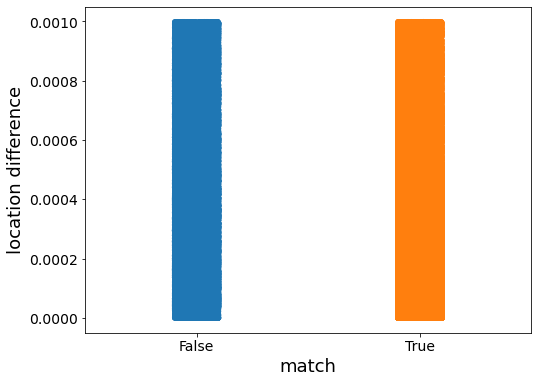

In [90]:
fig, ax = plt.subplots(figsize = (8,6))
sns.stripplot(x="match", y="location_diff", data=df_pairs.loc[df_pairs.location_diff<0.001], ax=ax)
ax.set_ylabel(r"location difference", fontsize=18)
ax.set_xlabel("match", fontsize=18)
ax.tick_params(labelsize=14)
plt.show()

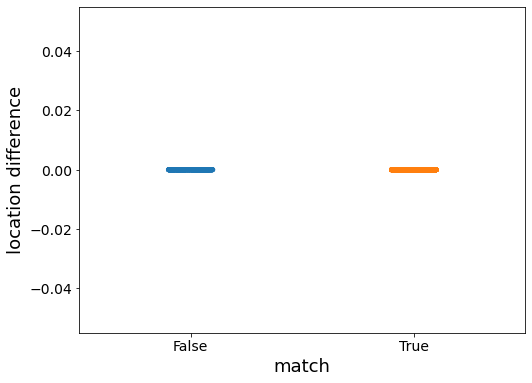

In [91]:
fig, ax = plt.subplots(figsize = (8,6))
sns.stripplot(x="match", y="location_diff", data=df_pairs.loc[df_pairs.location_diff==0],ax=ax)
ax.set_ylabel(r"location difference", fontsize=18)
ax.set_xlabel("match", fontsize=18)
ax.tick_params(labelsize=14)
plt.show()

In [93]:
print('There are',len(df_pairs.loc[(df_pairs.location_diff==0) & (df_pairs.match==False)]),
      'df_pairs with location_diff=0 but different POIs, out of all',len(df_pairs),'df_pairs.')

There are 574 df_pairs with location_diff=0 but different POIs, out of all 578907 df_pairs.


### name

  * There are some true pairs with slightly different names, e.g. short name v.s. full name.
  * Conversely, there are false pairs with the same name, e.g. chain stores in different cities.

In [94]:
df_pairs.loc[df_pairs.match==True].values[0]

array(['E_000001272c6c5d', 'Café Stad Oudenaarde', 50.85997533509319,
       3.6341963487748346, 'Abdijstraat', 'Nederename', 'Oost-Vlaanderen',
       '9700', 'BE', nan, nan, 'Bars', 'E_da7fa3963561f8',
       'Café Oudenaarde', 50.869358, 3.635206, nan, nan, nan, nan, 'BE',
       nan, nan, 'Bars', True, 0.009382664906809168], dtype=object)

In [95]:
df_pairs.loc[(df_pairs.name_1==df_pairs.name_2)&(df_pairs.name_1=="McDonald's")&(df_pairs.match==True)].values[0]

array(['E_0054712d9d9857', "McDonald's", 41.80434733686549,
       -88.04684628582879, '2535 Ogden Ave', 'Downers Grove', 'IL',
       '60515', 'US',
       'https://www.mcdonalds.com/us/en-us/location/il/downers-grove/2535-ogden-ave/36793.html',
       '+16309647433', 'Fast Food Restaurants', 'E_3d2134a9e1c29a',
       "McDonald's", 41.802858161557765, -88.14267043789413,
       '2535 Ogden Ave', 'Downers Grove', 'IL', '60515', 'US', nan, nan,
       'American Restaurants', True, 0.09582415206533312], dtype=object)

### address

### Filling NAs and  Making Combined Full Addresses

In [96]:
df_pairs['categories_1']   = df_pairs['categories_1'].fillna('')
df_pairs['categories_2']   = df_pairs['categories_2'].fillna('')
df_pairs['full_address_1'] = df_pairs['address_1'].fillna('') + ' ' + df_pairs['city_1'].fillna('') + ' ' + df_pairs['state_1'].fillna('') + ' ' + df_pairs['zip_1'].fillna('')  + ' ' + df_pairs['country_1'].fillna('')

In [97]:
df_pairs['full_address_1'] = df_pairs['address_1'].fillna('') + ' ' + df_pairs['city_1'].fillna('') + ' ' + df_pairs['state_1'].fillna('') + ' ' + df_pairs['zip_1'].fillna('')  + ' ' + df_pairs['country_1'].fillna('')
df_pairs['full_address_2'] = df_pairs['address_2'].fillna('') + ' ' + df_pairs['city_2'].fillna('') + ' ' + df_pairs['state_2'].fillna('') + ' ' + df_pairs['zip_2'].fillna('')  + ' ' + df_pairs['country_2'].fillna('')

### Reducing to only columns that seems useful. (Mostly based on shear amount of nans)

In [98]:
column_list = ['id_1','name_1', 'latitude_1', 'longitude_1', 'country_1', 'full_address_1', 'categories_1', 'id_2','name_2', 'latitude_2', 'longitude_2', 'country_2', 'full_address_2', 'categories_2', 'match']

In [100]:
pairs_reduced = df_pairs[column_list]

In [101]:
pairs_reduced.head()

,id_1,name_1,latitude_1,longitude_1,country_1,full_address_1,categories_1,id_2,name_2,latitude_2,longitude_2,country_2,full_address_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,BE,Abdijstraat Nederename Oost-Vlaanderen 9700 BE,Bars,E_da7fa3963561f8,Café Oudenaarde,50.869358,3.635206,BE,BE,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,TR,Adnan Menderes Bulvarı TR,Mobile Phone Shops,E_3f12df0b045062,Turkcell,37.838020,27.845560,TR,batı aydın aydın 67500 TR,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,PH,"5th Flr, Newport Mall, Resorts World Manila Pa...",Spas,E_12453effe251db,Island Spa Theater,14.518330,121.019827,PH,PH,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,US,"1380 Holiday Ln., Ste. B Fairfield CA 94534 US",Sandwich Places,E_f131dcb7f07be9,Togo's,38.257938,-122.064606,US,Fairfield CA US,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,PH,F. Torres St. Davao City Davao Region 8000 PH,"Cafés, Coffee Shops",E_d52c3c4d53831c,Coffeecat,7.076016,125.611457,PH,E. Jacinto Extension Davao City Davao Region 8...,"Coffee Shops, Cafés, Dessert Shops",False


In [102]:
pairs_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578907 entries, 0 to 578906
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_1            578907 non-null  object 
 1   name_1          578907 non-null  object 
 2   latitude_1      578907 non-null  float64
 3   longitude_1     578907 non-null  float64
 4   country_1       578899 non-null  object 
 5   full_address_1  578907 non-null  object 
 6   categories_1    578907 non-null  object 
 7   id_2            578907 non-null  object 
 8   name_2          578907 non-null  object 
 9   latitude_2      578907 non-null  float64
 10  longitude_2     578907 non-null  float64
 11  country_2       578901 non-null  object 
 12  full_address_2  578907 non-null  object 
 13  categories_2    578907 non-null  object 
 14  match           578907 non-null  bool   
dtypes: bool(1), float64(4), object(10)
memory usage: 62.4+ MB


### Calculating angular difference of latitude and longitude

In [ ]:
# pairs_reduced['theta_diff'] = np.arccos(np.sin(np.radians(pairs_reduced['latitude_1']))*np.sin(np.radians(pairs_reduced['latitude_2']))+
#                                        np.cos(np.radians(pairs_reduced['latitude_1']))*np.cos(np.radians(pairs_reduced['latitude_2']))*
#                                         np.cos(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2']))
#                                        )

In [ ]:
pairs_reduced['theta_diff'] = np.abs(np.arctan(np.sqrt(
    (np.cos(np.radians(pairs_reduced['latitude_2']))*np.sin(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2'])))**2 +
        (np.cos(np.radians(pairs_reduced['latitude_1']))*np.sin(np.radians(pairs_reduced['latitude_2']))-
            np.sin(np.radians(pairs_reduced['latitude_1']))*np.cos(np.radians(pairs_reduced['latitude_2']))*np.cos(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2'])))**2
                                                )/
    (np.sin(np.radians(pairs_reduced['latitude_1']))*np.sin(np.radians(pairs_reduced['latitude_2']))+
        np.cos(np.radians(pairs_reduced['latitude_1']))*np.cos(np.radians(pairs_reduced['latitude_2']))*np.cos(np.radians(pairs_reduced['longitude_1']-pairs_reduced['longitude_2']))
    )
                                               )
                                      )

<ipython-input-46-4562924af0b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_reduced['theta_diff'] = np.abs(np.arctan(np.sqrt(


In [ ]:
# pairs_reduced['theta_diff'] = np.sqrt((np.radians(pairs_reduced['longitude_1'])-np.radians(pairs_reduced['longitude_2'])*np.cos(np.radians(pairs_reduced['latitude_1'])))**2 +
#         (np.radians(pairs_reduced['latitude_1'])-np.radians(pairs_reduced['latitude_2']))**2
#        )

In [ ]:
# pairs_reduced['theta_diff'] = (np.radians(pairs_reduced['longitude_1'])-np.radians(pairs_reduced['longitude_2']))**2 + (np.radians(pairs_reduced['latitude_1'])-np.radians(pairs_reduced['latitude_2']))**2

In [ ]:
pairs_reduced[pairs_reduced['theta_diff'].isna()]

,id_1,name_1,latitude_1,longitude_1,country_1,full_address_1,categories_1,id_2,name_2,latitude_2,longitude_2,country_2,full_address_2,categories_2,match,theta_diff


# Reducing `pairs.csv` to only US data

In [ ]:
len(pairs_reduced[(pairs_reduced['country_1'] == 'US') & (pairs_reduced['country_1'] == 'US')])

117793

Dropping no longer needed columns

In [ ]:
pairs_red_us = pairs_reduced[(pairs_reduced['country_1'] == 'US') & (pairs_reduced['country_1'] == 'US')]

In [ ]:
pairs_red_us = pairs_red_us.drop(['country_1','country_2', 'latitude_1', 'longitude_1', 'latitude_2', 'longitude_2'], axis = 1)

In [ ]:
pairs_red_us.head()

,id_1,name_1,full_address_1,categories_1,id_2,name_2,full_address_2,categories_2,match,theta_diff
3,E_00007dcd2bb53f,TOGO'S Sandwiches,"1380 Holiday Ln., Ste. B Fairfield CA 94534 US",Sandwich Places,E_f131dcb7f07be9,Togo's,Fairfield CA US,Sandwich Places,True,0.000002
6,E_0000d9e584ed9f,Signature Properties Savannah,100 Commercial Ct Ste C Savannah GA 31406 US,Real Estate Offices,E_caad79f6ed7c44,Signature Properties Savannah,7014 Abercorn St Savannah GA 31406 US,NaN,True,0.000082
7,E_00011cca3f0bd6,Inner Workings,Serving General Area Santa Fe NM 87501 US,Massage Studios,E_aeffddf31a4b9e,Inner Workings,Serving General Area Santa Fe NM 87501 US,Massage Studios,True,0.000019
8,E_00015cd7e0227f,Lake Destiny,Maitland FL 32751 US,Lakes,E_7250ab441d9d42,Lake destiny field,Maitland FL 32751 US,Soccer Fields,False,0.000253
11,E_0001a397f67ad5,Dale City Truck-Only Safety Rest Area North,Interstate 95 North Montclair VA 22026 US,Rest Areas,E_4b83e498f06eff,I-95 Exit 152 Truck Stop,Dumfries VA 22026 US,Rest Areas,True,0.000119


It's probably in my best interest to lower case all of the strings when doing the string matching aspect

In [ ]:
pairs_red_us['name_1'] = pairs_red_us['name_1'].astype(str)
pairs_red_us['name_2'] = pairs_red_us['name_2'].astype(str)
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].astype(str)
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].astype(str)
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].astype(str)
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].astype(str)

pairs_red_us['name_1'] = pairs_red_us['name_1'].str.lower()
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].str.lower()
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].str.lower()
pairs_red_us['name_2'] = pairs_red_us['name_2'].str.lower()
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].str.lower()
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].str.lower()

In [ ]:
pairs_red_us.head()

,id_1,name_1,full_address_1,categories_1,id_2,name_2,full_address_2,categories_2,match,theta_diff
3,E_00007dcd2bb53f,togo's sandwiches,"1380 holiday ln., ste. b fairfield ca 94534 us",sandwich places,E_f131dcb7f07be9,togo's,fairfield ca us,sandwich places,True,0.000002
6,E_0000d9e584ed9f,signature properties savannah,100 commercial ct ste c savannah ga 31406 us,real estate offices,E_caad79f6ed7c44,signature properties savannah,7014 abercorn st savannah ga 31406 us,,True,0.000082
7,E_00011cca3f0bd6,inner workings,serving general area santa fe nm 87501 us,massage studios,E_aeffddf31a4b9e,inner workings,serving general area santa fe nm 87501 us,massage studios,True,0.000019
8,E_00015cd7e0227f,lake destiny,maitland fl 32751 us,lakes,E_7250ab441d9d42,lake destiny field,maitland fl 32751 us,soccer fields,False,0.000253
11,E_0001a397f67ad5,dale city truck-only safety rest area north,interstate 95 north montclair va 22026 us,rest areas,E_4b83e498f06eff,i-95 exit 152 truck stop,dumfries va 22026 us,rest areas,True,0.000119


I tihnk I can drop ids as well

In [ ]:
pairs_red_us = pairs_red_us.drop(['id_1', 'id_2'], axis = 1)

In [ ]:
len(pairs_red_us['name_1'])

117793

In [ ]:
len(pairs_red_us['name_1'][pairs_red_us['name_1'].isna()])

0

In [ ]:
pairs_red_us['name_1'].tolist()[1:100]

['signature properties savannah',
 'inner workings',
 'lake destiny',
 'dale city truck-only safety rest area north',
 'del mar motel',
 'trinity united methodist church',
 'la quinta inn & suites memphis wolfchase',
 'la quinta inn & suites memphis wolfchase',
 'apa hotel woodbridge',
 'g&m',
 'g&m',
 'hampton inn & suites',
 'the home depot',
 'scoots',
 'potbelly sandwich shop',
 'jibarra',
 'seaport village',
 'witt ford',
 'harbor freight tools',
 'local@biztraffic.com',
 'walmart neighborhood market',
 'la quinta inn & suites jacksonville mandarin',
 "nick's liquors",
 'adp alpharetta',
 'north terre haute, in',
 'gucci男士内裤-一比一原单a货奢侈品他',
 'brookville dental associates',
 'carmax',
 'sun devil marketplace',
 'premier relocations',
 'zoom tan - tanning salon',
 'tecumseh elementary school',
 'asha indian restaurant',
 'lambo chinese buffet',
 'the galley',
 'rockledge dental',
 'stellar car services',
 'panda express',
 'mhc truck leasing - atlanta',
 'sears auto center',
 'jamba j

Now following the article "Calculating STring Similarity in Python"

In [ ]:
pairs_red_us['name_1']

3                                   togo's sandwiches
6                       signature properties savannah
7                                      inner workings
8                                        lake destiny
11        dale city truck-only safety rest area north
                             ...                     
578885                                        talbots
578888                                    bank street
578890                             signature plumbing
578900                                      walgreens
578904           cricket wireless authorized retailer
Name: name_1, Length: 117793, dtype: object

In [ ]:
pairs_red_us['name_1'] = pairs_red_us['name_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['name_2'] = pairs_red_us['name_2'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['full_address_1'] = pairs_red_us['full_address_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['full_address_2'] = pairs_red_us['full_address_2'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['categories_1'] = pairs_red_us['categories_1'].str.replace('[{}]'.format(string.punctuation),'')
pairs_red_us['categories_2'] = pairs_red_us['categories_2'].str.replace('[{}]'.format(string.punctuation),'')

In [ ]:
pairs_red_us['name_1'].iloc[0]

'togos sandwiches'

In [ ]:
pairs_red_us.head()

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff
3,togos sandwiches,1380 holiday ln ste b fairfield ca 94534 us,sandwich places,togos,fairfield ca us,sandwich places,True,0.000002
6,signature properties savannah,100 commercial ct ste c savannah ga 31406 us,real estate offices,signature properties savannah,7014 abercorn st savannah ga 31406 us,,True,0.000082
7,inner workings,serving general area santa fe nm 87501 us,massage studios,inner workings,serving general area santa fe nm 87501 us,massage studios,True,0.000019
8,lake destiny,maitland fl 32751 us,lakes,lake destiny field,maitland fl 32751 us,soccer fields,False,0.000253
11,dale city truckonly safety rest area north,interstate 95 north montclair va 22026 us,rest areas,i95 exit 152 truck stop,dumfries va 22026 us,rest areas,True,0.000119


In [ ]:
pairs_red_us = pairs_red_us.reset_index().drop('index', axis = 1)

In [ ]:
pairs_red_us.head()

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff
0,togos sandwiches,1380 holiday ln ste b fairfield ca 94534 us,sandwich places,togos,fairfield ca us,sandwich places,True,0.000002
1,signature properties savannah,100 commercial ct ste c savannah ga 31406 us,real estate offices,signature properties savannah,7014 abercorn st savannah ga 31406 us,,True,0.000082
2,inner workings,serving general area santa fe nm 87501 us,massage studios,inner workings,serving general area santa fe nm 87501 us,massage studios,True,0.000019
3,lake destiny,maitland fl 32751 us,lakes,lake destiny field,maitland fl 32751 us,soccer fields,False,0.000253
4,dale city truckonly safety rest area north,interstate 95 north montclair va 22026 us,rest areas,i95 exit 152 truck stop,dumfries va 22026 us,rest areas,True,0.000119


In [ ]:
pairs_red_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_reduced_us.csv')

In [ ]:
vectors = CountVectorizer().fit_transform([pairs_red_us['name_1'].iloc[0], pairs_red_us['name_2'].iloc[0]]).toarray()

In [ ]:
csim = cosine_similarity(vectors)

In [ ]:
csim

array([[1.        , 0.70710678],
       [0.70710678, 1.        ]])

In [ ]:
csim[0][1]

0.7071067811865475

In [ ]:
range(len(pairs_red_us.iloc[:]))

range(0, 117793)

In [ ]:
name_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['name_1'].iloc[i] == '') | (pairs_red_us['name_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['name_1'].iloc[i], pairs_red_us['name_2'].iloc[i]]).toarray())[0][1]
    name_cosines.append(csim)

In [ ]:
len(name_cosines)

117793

In [ ]:
pairs_red_us['name_cosines'] = pd.DataFrame(name_cosines)

In [ ]:
pairs_red_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117793 entries, 0 to 117792
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name_1          117793 non-null  object 
 1   full_address_1  117793 non-null  object 
 2   categories_1    117793 non-null  object 
 3   name_2          117793 non-null  object 
 4   full_address_2  117793 non-null  object 
 5   categories_2    117793 non-null  object 
 6   match           117793 non-null  bool   
 7   theta_diff      117793 non-null  float64
 8   name_cosines    117793 non-null  float64
dtypes: bool(1), float64(2), object(6)
memory usage: 7.3+ MB


In [ ]:
pairs_red_us[pairs_red_us['name_cosines'].isna()]

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff,name_cosines


In [ ]:
pairs_red_us[pairs_red_us['categories_2'].isna()]

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff,name_cosines


In [ ]:
pairs_red_us.head()

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff,name_cosines
0,togos sandwiches,1380 holiday ln ste b fairfield ca 94534 us,sandwich places,togos,fairfield ca us,sandwich places,True,0.000002,0.707107
1,signature properties savannah,100 commercial ct ste c savannah ga 31406 us,real estate offices,signature properties savannah,7014 abercorn st savannah ga 31406 us,,True,0.000082,1.000000
2,inner workings,serving general area santa fe nm 87501 us,massage studios,inner workings,serving general area santa fe nm 87501 us,massage studios,True,0.000019,1.000000
3,lake destiny,maitland fl 32751 us,lakes,lake destiny field,maitland fl 32751 us,soccer fields,False,0.000253,0.816497
4,dale city truckonly safety rest area north,interstate 95 north montclair va 22026 us,rest areas,i95 exit 152 truck stop,dumfries va 22026 us,rest areas,True,0.000119,0.000000


In [ ]:
address_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['full_address_1'].iloc[i] == '') | (pairs_red_us['full_address_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['full_address_1'].iloc[i], pairs_red_us['full_address_2'].iloc[i]]).toarray())[0][1]
    address_cosines.append(csim)

pairs_red_us['full_address_cosines'] = pd.DataFrame(address_cosines)

In [ ]:
pairs_red_us.head()

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff,name_cosines,full_address_cosines
0,togos sandwiches,1380 holiday ln ste b fairfield ca 94534 us,sandwich places,togos,fairfield ca us,sandwich places,True,0.000002,0.707107,0.612372
1,signature properties savannah,100 commercial ct ste c savannah ga 31406 us,real estate offices,signature properties savannah,7014 abercorn st savannah ga 31406 us,,True,0.000082,1.000000,0.534522
2,inner workings,serving general area santa fe nm 87501 us,massage studios,inner workings,serving general area santa fe nm 87501 us,massage studios,True,0.000019,1.000000,1.000000
3,lake destiny,maitland fl 32751 us,lakes,lake destiny field,maitland fl 32751 us,soccer fields,False,0.000253,0.816497,1.000000
4,dale city truckonly safety rest area north,interstate 95 north montclair va 22026 us,rest areas,i95 exit 152 truck stop,dumfries va 22026 us,rest areas,True,0.000119,0.000000,0.566947


In [ ]:
categories_cosines = []
for i in range(len(pairs_red_us)):
    if (pairs_red_us['categories_1'].iloc[i] == '') | (pairs_red_us['categories_2'].iloc[i] == ''):
        csim = -1
    else:
        csim = cosine_similarity(CountVectorizer().fit_transform([pairs_red_us['categories_1'].iloc[i], pairs_red_us['categories_2'].iloc[i]]).toarray())[0][1]
    categories_cosines.append(csim)
    
pairs_red_us['categories_cosines'] = pd.DataFrame(categories_cosines)

In [ ]:
pairs_red_us.head()

,name_1,full_address_1,categories_1,name_2,full_address_2,categories_2,match,theta_diff,name_cosines,full_address_cosines,categories_cosines
0,togos sandwiches,1380 holiday ln ste b fairfield ca 94534 us,sandwich places,togos,fairfield ca us,sandwich places,True,0.000002,0.707107,0.612372,1.0
1,signature properties savannah,100 commercial ct ste c savannah ga 31406 us,real estate offices,signature properties savannah,7014 abercorn st savannah ga 31406 us,,True,0.000082,1.000000,0.534522,-1.0
2,inner workings,serving general area santa fe nm 87501 us,massage studios,inner workings,serving general area santa fe nm 87501 us,massage studios,True,0.000019,1.000000,1.000000,1.0
3,lake destiny,maitland fl 32751 us,lakes,lake destiny field,maitland fl 32751 us,soccer fields,False,0.000253,0.816497,1.000000,0.0
4,dale city truckonly safety rest area north,interstate 95 north montclair va 22026 us,rest areas,i95 exit 152 truck stop,dumfries va 22026 us,rest areas,True,0.000119,0.000000,0.566947,1.0


In [ ]:
pairs_final_diffed_us = pairs_red_us[['theta_diff', 'name_cosines', 'full_address_cosines', 'categories_cosines', 'match']]

In [ ]:
pairs_final_diffed_us

,theta_diff,name_cosines,full_address_cosines,categories_cosines,match
0,0.000002,0.707107,0.612372,1.000000,True
1,0.000082,1.000000,0.534522,-1.000000,True
2,0.000019,1.000000,1.000000,1.000000,True
3,0.000253,0.816497,1.000000,0.000000,False
4,0.000119,0.000000,0.566947,1.000000,True
...,...,...,...,...,...
117788,0.000691,1.000000,0.408248,0.816497,True
117789,0.000034,0.408248,0.750000,0.000000,False
117790,0.000002,1.000000,1.000000,0.000000,True
117791,0.001709,1.000000,0.235702,0.316228,False


# Exploring the transformed data

In [ ]:
pairs_final_diffed_us['theta_diff']

0         0.000002
1         0.000082
2         0.000019
3         0.000253
4         0.000119
            ...   
117788    0.000691
117789    0.000034
117790    0.000002
117791    0.001709
117792    0.000136
Name: theta_diff, Length: 117793, dtype: float64

In [ ]:
pairs_final_diffed_us.describe()

,theta_diff,name_cosines,full_address_cosines,categories_cosines
count,117793.000000,117793.000000,117793.000000,117793.000000
mean,0.001800,0.649019,0.781899,0.468062
std,0.029048,0.359314,0.218063,0.616417
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000005,0.408248,0.632456,0.000000
50%,0.000019,0.707107,0.816497,0.707107
75%,0.000099,1.000000,1.000000,1.000000
max,1.563694,1.000000,1.000000,1.000000


In [ ]:
import seaborn as sns

In [ ]:
pairs_corr = pairs_final_diffed_us.corr()

<AxesSubplot:>

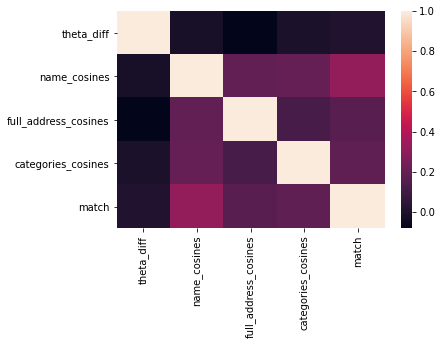

In [ ]:
sns.heatmap(pairs_corr)

In [ ]:
pairs_corr

,theta_diff,name_cosines,full_address_cosines,categories_cosines,match
theta_diff,1.000000,-0.009203,-0.080235,-0.001742,0.014765
name_cosines,-0.009203,1.000000,0.192721,0.202642,0.318856
full_address_cosines,-0.080235,0.192721,1.000000,0.125937,0.169836
categories_cosines,-0.001742,0.202642,0.125937,1.000000,0.187185
match,0.014765,0.318856,0.169836,0.187185,1.000000


In [ ]:
pairs_final_diffed_us['theta_diff'][pairs_final_diffed_us['match']==True].describe()

count    84674.000000
mean         0.002068
std          0.029835
min          0.000000
25%          0.000004
50%          0.000017
75%          0.000124
max          1.556511
Name: theta_diff, dtype: float64

In [ ]:
pairs_final_diffed_us['theta_diff'][pairs_final_diffed_us['match']==False].describe()

count    33119.000000
mean         0.001114
std          0.026920
min          0.000000
25%          0.000008
50%          0.000023
75%          0.000069
max          1.563694
Name: theta_diff, dtype: float64

In [ ]:
pairs_final_diffed_us.describe()

,theta_diff,name_cosines,full_address_cosines,categories_cosines
count,117793.000000,117793.000000,117793.000000,117793.000000
mean,0.001800,0.649019,0.781899,0.468062
std,0.029048,0.359314,0.218063,0.616417
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000005,0.408248,0.632456,0.000000
50%,0.000019,0.707107,0.816497,0.707107
75%,0.000099,1.000000,1.000000,1.000000
max,1.563694,1.000000,1.000000,1.000000


In [ ]:
pairs_final_diffed_us.head()

,theta_diff,name_cosines,full_address_cosines,categories_cosines,match
0,0.000002,0.707107,0.612372,1.0,True
1,0.000082,1.000000,0.534522,-1.0,True
2,0.000019,1.000000,1.000000,1.0,True
3,0.000253,0.816497,1.000000,0.0,False
4,0.000119,0.000000,0.566947,1.0,True


In [ ]:
pairs_final_diffed_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us.csv')

## Optional Scaling

In [ ]:
pairs_final_diffed_us = pd.read_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us.csv')

In [ ]:
pairs_final_diffed_us = pairs_final_diffed_us.drop('Unnamed: 0', axis =1)

In [ ]:
pairs_final_diffed_us.head()

,theta_diff,name_cosines,full_address_cosines,categories_cosines,match
0,0.000002,0.707107,0.612372,1.0,True
1,0.000082,1.000000,0.534522,-1.0,True
2,0.000019,1.000000,1.000000,1.0,True
3,0.000253,0.816497,1.000000,0.0,False
4,0.000119,0.000000,0.566947,1.0,True


In [ ]:
pairs_final_diffed_us.describe()

,theta_diff,name_cosines,full_address_cosines,categories_cosines
count,117793.000000,117793.000000,117793.000000,117793.000000
mean,0.001800,0.649019,0.781899,0.468062
std,0.029048,0.359314,0.218063,0.616417
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000005,0.408248,0.632456,0.000000
50%,0.000019,0.707107,0.816497,0.707107
75%,0.000099,1.000000,1.000000,1.000000
max,1.563694,1.000000,1.000000,1.000000


In [ ]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['theta_diff', 'name_cosines', 'full_address_cosines', 'categories_cosines']
scaler = StandardScaler()
scaler.fit(pairs_final_diffed_us[cols_to_scale])
pairs_final_diffed_us[cols_to_scale] = scaler.transform(pairs_final_diffed_us[cols_to_scale])

In [ ]:
pairs_final_diffed_us.describe()

,theta_diff,name_cosines,full_address_cosines,categories_cosines
count,1.177930e+05,1.177930e+05,1.177930e+05,1.177930e+05
mean,-5.673124e-17,-6.075524e-16,-4.158984e-16,2.867844e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-6.195319e-02,-1.806282e+00,-3.585681e+00,-2.381617e+00
25%,-6.178098e-02,-6.700873e-01,-6.853287e-01,-7.593302e-01
50%,-6.129996e-02,1.616648e-01,1.586576e-01,3.877996e-01
75%,-5.853338e-02,9.768149e-01,1.000179e+00,8.629563e-01
max,5.376932e+01,9.768149e-01,1.000179e+00,8.629563e-01


In [ ]:
pairs_final_diffed_us.to_csv(r'C:\Users\gorma\OneDrive\Documents\Erdos\foursquare-location-matching\tim_code\working_data\pairs_final_diffed_us_scaled.csv', index = False)

# Comparing string features

Most columns in this data are strings. We consider different metrics for string comparison letter by letter, including:

*   `SequenceMatcher`
*   `Levenshtein distance`

or word by word using a `CountVectorizer` and `cosine_similarity`

If one value of a pair of features is missing, we set the distance to be -1.



In [ ]:
from difflib import SequenceMatcher
import math
# Reference: https://stackoverflow.com/questions/43916271/python-pandas-sequencematch-columns-for-each-value-and-return-closet-match

def seq_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        
    return 1-SequenceMatcher(None, a, b).ratio()

In [ ]:
!pip install python-Levenshtein

from Levenshtein import distance as lev
def lev_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    #if a in b or b in a: 
    #    return 0
    return lev(a,b)/max(len(a),len(b))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def countvec_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace("'", "")
        b = b.lower().replace("'", "")
    return cosine_similarity(CountVectorizer().fit_transform([a,b]).toarray())[0][1]

In [ ]:
# The following function allows us to apply different metric on the columns of pairs.csv to generate distance between features.
def compute_diffs(df, cols, string_metric):
    df_copy = df
    for col in cols:
        df_copy[col+'_diff'] = df.apply(string_metric,
                          args=(col+'_1', col+'_2'),
                          axis=1)
    return df_copy[ ['id_1','id_2','match']+['location_diff']+ [col+'_diff' for col in cols] ]

We now construct the new dataframe with the selected feactures and chosen methods to compute a metric between the features.

In [ ]:
# Using SequenceMatcher

columns = ['name', 'address', 'city', 'state',
       'zip', 'url', 'phone', 'categories']
       
df_pairs_seq = compute_diffs(df_pairs, columns, seq_metric)

In [ ]:
# Using Levenshtein distance

columns = ['name', 'address', 'city', 'state',
       'zip', 'url', 'phone', 'categories']
       
df_pairs_lev = compute_diffs(df_pairs, columns, lev_metric)

In [ ]:
# Using CountVectorizer

columns = ['name']#, 'address', 'city', 'state', 'zip', 'url', 'phone', 'categories']
       
df_pairs_count = compute_diffs(df_pairs, columns, countvec_metric)

ValueError: ignored

## Histogram

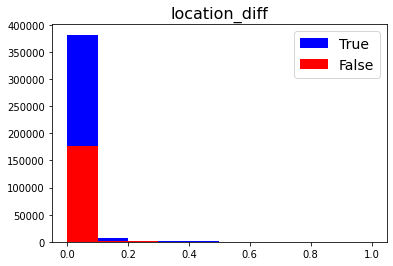

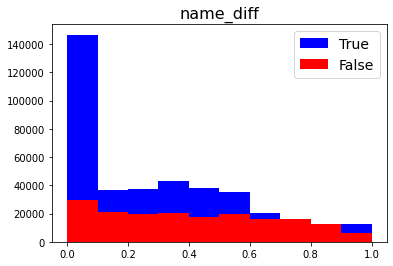

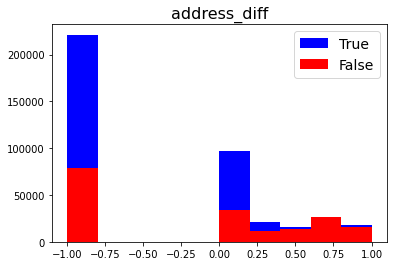

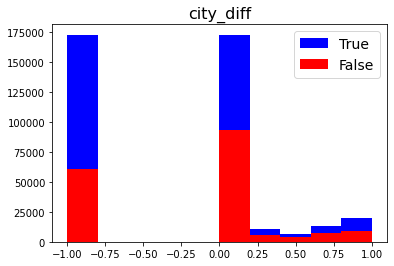

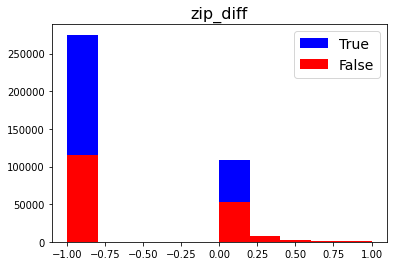

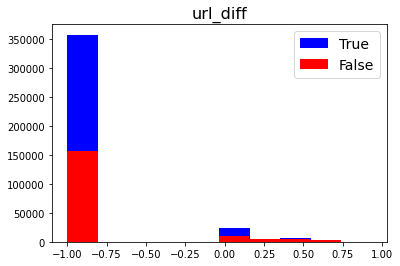

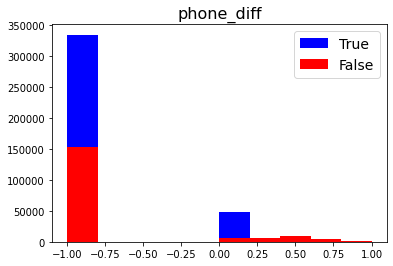

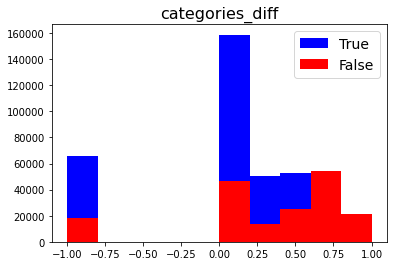

In [ ]:
## histograms for SequenceMatcher

columns = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

for i in range(len(columns)):
    column=columns[i]
    plt.hist(df_pairs_seq.loc[(df_pairs_seq.match==True)&(df_pairs_seq.location_diff<1), column], color='b', label="True")
    plt.hist(df_pairs_seq.loc[(df_pairs_seq.match==False)&(df_pairs_seq.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

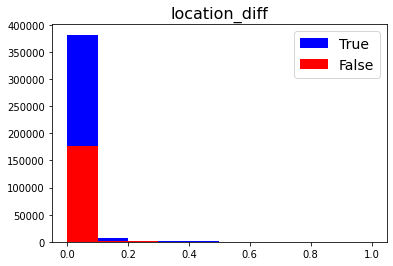

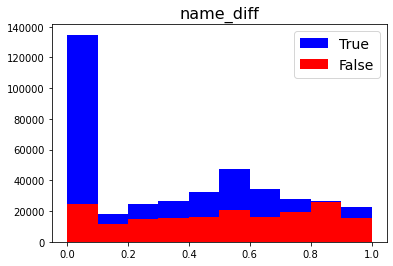

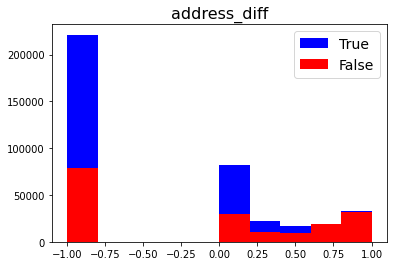

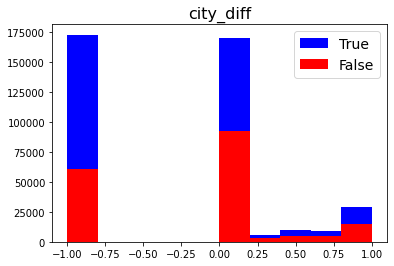

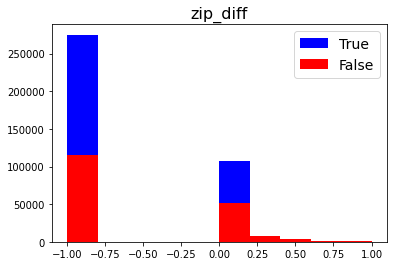

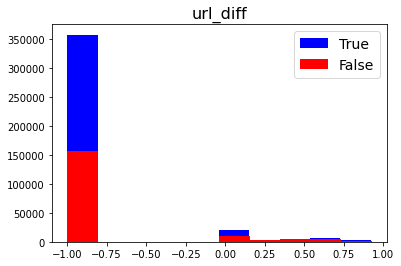

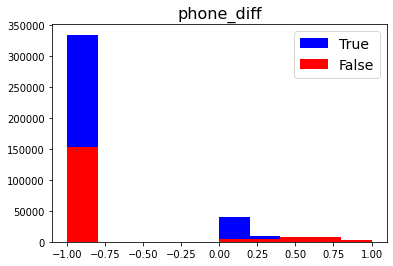

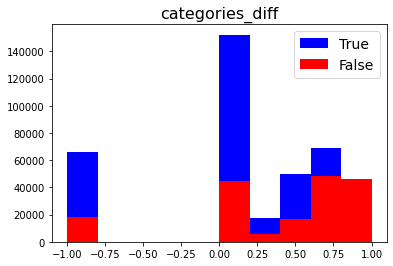

In [ ]:
# Histogram for Levenshtein distance

columns = ['location_diff','name_diff','address_diff','city_diff','zip_diff','url_diff', 'phone_diff', 'categories_diff']

for i in range(len(columns)):
    column=columns[i]
    plt.hist(df_pairs_lev.loc[(df_pairs_lev.match==True)&(df_pairs_lev.location_diff<1), column], color='b', label="True")
    plt.hist(df_pairs_lev.loc[(df_pairs_lev.match==False)&(df_pairs_lev.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

# To improve (to be filled)



1.   Generate more pairs: mention how many pairs there are blabla
2.   Consider places in other countries blabla
3.   Filling in missing values: for example, zip codes can be obtained from the coordinates.
4.   Balance the dataset: change the ratio of true/false pairs blabla.

